# Fraud Detection (PaySim) — End‑to‑End Notebook (Minimal Functions)
This version relies on libraries/frameworks and vectorized operations, avoiding custom functions/loops.

In [1]:
%pip install mlflow


Note: you may need to restart the kernel to use updated packages.


## 1) Load Data from Azure ML Data Asset

In [2]:
import os, zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from azureml.core import Workspace, Dataset

ws = Workspace.from_config()
dataset = Dataset.get_by_name(ws, 'paysim_fraud_v1')

local_paths = dataset.download(target_path='data', overwrite=True)
zip_path = [p for p in local_paths if p.endswith('.zip')][0]

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall('data')

csv_path = [os.path.join('data', f) for f in os.listdir('data') if f.endswith('.csv')][0]
df = pd.read_csv(csv_path)
df.head()

{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 2) EDA

In [3]:
df.shape

(6362620, 11)

In [4]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [5]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

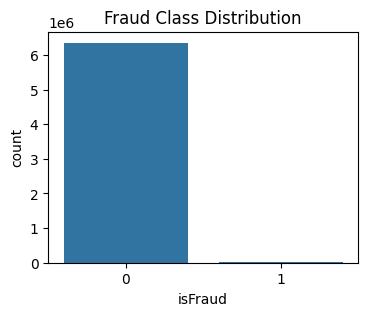

In [8]:
plt.figure(figsize=(4,3))
sns.countplot(x='isFraud', data=df)
plt.title('Fraud Class Distribution')
plt.show()

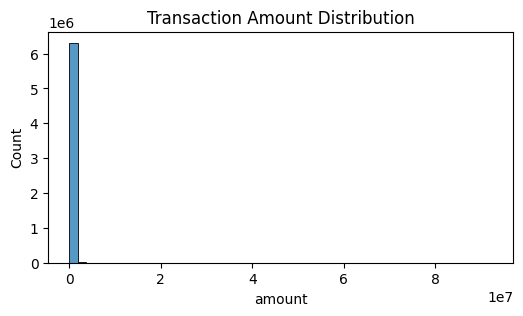

In [9]:
plt.figure(figsize=(6,3))
sns.histplot(df['amount'], bins=50)
plt.title('Transaction Amount Distribution')
plt.show()

## 3) Feature Engineering (Behavioral Proxies)

In [10]:
df = df.copy()
df['amount_to_balance'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['amount_vs_dest_balance'] = df['amount'] / (df['oldbalanceDest'] + 1)
df['balance_change_org'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['is_night'] = ((df['step'] % 24) <= 6).astype(int)
df[['amount_to_balance','amount_vs_dest_balance','balance_change_org','balance_change_dest','is_night']].head()

,amount_to_balance,amount_vs_dest_balance,balance_change_org,balance_change_dest,is_night
0,0.057834,9839.640000,9839.64,0.0,1
1,0.087731,1864.280000,1864.28,0.0,1
2,0.994505,181.000000,181.00,0.0,1
3,0.994505,0.008545,181.00,-21182.0,1
4,0.280788,11668.140000,11668.14,0.0,1


## 4) Prepare Features

In [11]:
# Use numeric features only
feature_cols = [
    'step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
    'amount_to_balance','amount_vs_dest_balance','balance_change_org','balance_change_dest','is_night'
]

# SAMPLE to keep compute stable
df_sample = df.sample(300000, random_state=42)
X_sample = df_sample[feature_cols].fillna(0)
y_sample = df_sample['isFraud']


In [12]:
# Optional: sample to reduce memory load
df_sample = df.sample(300000, random_state=42)
X_sample = df_sample[feature_cols].fillna(0)


## 5) Isolation Forest

In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

iso = IsolationForest(n_estimators=300, max_samples=0.8, contamination=0.01, random_state=42)
iso.fit(X_sample_scaled)
iso_score = -iso.decision_function(X_sample_scaled)  # higher = more anomalous
iso_score[:5]


array([-0.126104  , -0.13749105, -0.1250991 , -0.0777797 , -0.1104006 ])

## 6) DBSCAN (Cluster‑Based Anomalies)

In [14]:
# sanity check
print("df exists:", "df" in globals())
print("X_scaled exists:", "X_scaled" in globals())


df exists: True
X_scaled exists: False


In [15]:
print("X_sample_scaled exists:", "X_sample_scaled" in globals())


X_sample_scaled exists: True


In [16]:
from sklearn.cluster import DBSCAN

# ensure X_sample_scaled exists
# (this assumes you've already run the scaling cell)

db_idx = df_sample.sample(50000, random_state=42).index
X_db = X_sample_scaled[df_sample.index.get_indexer(db_idx)]

db = DBSCAN(eps=0.5, min_samples=5)
db_labels = db.fit_predict(X_db)

# map DBSCAN anomalies back to the full sample length
db_n = np.zeros(len(df_sample))
db_n[df_sample.index.get_indexer(db_idx)] = (db_labels == -1).astype(int)

db_n[:10]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## 7) Autoencoder (Neural Anomaly Detector)

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

X_ae = X_sample_scaled

input_dim = X_ae.shape[1]
encoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu')
])
decoder = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(8,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

ae = models.Sequential([encoder, decoder])
ae.compile(optimizer='adam', loss='mse')

ae.fit(X_ae, X_ae, epochs=10, batch_size=256, verbose=1)

recon = ae.predict(X_ae, batch_size=256)
ae_error = ((X_ae - recon) ** 2).mean(axis=1)
ae_error[:5]


2026-02-09 14:48:56.882162: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-09 14:48:59.366509: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/anaconda/envs/jupyter_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1665
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0233
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0162
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0127
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0092
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0098
Epoch 7/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089
Epoch 8/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0059
Epo

array([0.0013817 , 0.00048911, 0.0011966 , 0.00488252, 0.00024838])

## 8) Risk Scoring Engine + Alert Tiers

In [18]:
iso_n = (iso_score - iso_score.min()) / (iso_score.max() - iso_score.min() + 1e-9)
ae_n = (ae_error - ae_error.min()) / (ae_error.max() - ae_error.min() + 1e-9)

risk_score = 0.4 * iso_n + 0.4 * ae_n + 0.2 * db_n

risk_tier = pd.cut(
    risk_score,
    bins=[-0.01, 0.3, 0.6, 0.8, 1.0],
    labels=['Low','Review','High','Block']
)
risk_tier.value_counts()


Low       299179
Review       814
High           7
Block          0
Name: count, dtype: int64

## 9) Cost Analysis

In [19]:
threshold = 0.6
pred_fraud = (risk_score >= threshold).astype(int)

COST_FP = 50
COST_FN = 500

fp = int(((pred_fraud == 1) & (y_sample.values == 0)).sum())
fn = int(((pred_fraud == 0) & (y_sample.values == 1)).sum())

total_cost = fp * COST_FP + fn * COST_FN
fp, fn, total_cost


(6, 387, 193800)

## 10) Explainability Helpers

In [20]:
top_risk_idx = np.argsort(risk_score)[-10:]
df.loc[top_risk_idx, ['step','type','amount','nameOrig','nameDest','isFraud']].head()

,step,type,amount,nameOrig,nameDest,isFraud
243680,14,PAYMENT,1716.05,C977779743,M1535762891,0
250087,14,CASH_OUT,20768.44,C1928679517,C1486046100,0
188238,13,CASH_OUT,239112.02,C1832543361,C90454488,0
151919,12,CASH_OUT,5442.56,C977583635,C933872961,0
254044,14,PAYMENT,1750.34,C1612204103,M213348856,0


## 11) Export for Power BI

In [21]:
output = df_sample.copy()
output['risk_score'] = risk_score
output['risk_tier'] = risk_tier

output[['step','type','amount','isFraud','risk_score','risk_tier']].to_csv('fraud_scored.csv', index=False)
'fraud_scored.csv saved'


'fraud_scored.csv saved'

## 12) Model logging via. MLflow

In [22]:
import mlflow
mlflow.set_tracking_uri("file:/home/azureuser/mlruns")
mlflow.set_experiment("fraud_detection_experiment")

mlflow.log_metric("iso_mean_score", float(iso_score.mean()))
mlflow.log_metric("iso_max_score", float(iso_score.max()))
mlflow.end_run()

# generally MLflow logging is active by default in Azure ML studio


/anaconda/envs/jupyter_env/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


## 13) Model Creation

In [23]:
import joblib # model pkl creation

# Example: save Isolation Forest model
joblib.dump(iso, "iso_fraud_model.pkl")


['iso_fraud_model.pkl']